# 0. Who we are
We are the student of The University of Sydney(USYD) 2022_S1C_COMP5046_Assignment2_Group6

Our Unikey and SID are:

| Unikey | SID | Email|
|--------|-----| -----|
|zshi3507|500020645|zshi3507@uni.sydney.edu.au|
|ygan7134|500209804| ygan7134@uni.sydney.edu.au|



# 1. Data Pre-processing

## 1.1 Package Import

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Data Import

In [ ]:
'''
Authentication And Get Google API's Token
'''
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


'''
Download Data From Google Drive Template

id = ''
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('')
'''

#Download Traning Dataset
id = '1gt-0RVZBKXycx3JNniLuDT-toRbxLAJt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('training.csv')

#Download Validation Dataset
id = '1GTijLGRvD9ViOjEsFO81pcmgH2Ep-zgB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('val.csv')

#Download Testing Dataset
id = '1Ww-qNb2B3ew9ntZOt2FLUdX7vaHVb12j'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('test_without_labels.csv')

#Download Train_intent Dataset
id = '1P0yT59WaIsSgGE62i0kBext_d_v4ztIt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train_intent.csv')

#Reading Data From File To Memory
training_data = pd.read_csv("/content/training.csv")
validation_data = pd.read_csv("/content/val.csv")
testing_data = pd.read_csv("/content/test_without_labels.csv")
train_intent = pd.read_csv("/content/train_intent.csv")

In [ ]:
#Show What The Data Looks Like In Memory
training_data.head()

,sents,labels
0,wow,O
1,WTF,T
2,wpe wpe,O O
3,hahaha,O
4,wtf,T


In [ ]:
#Show What The Data Looks Like In Memory
validation_data.head()

,sents,labels
0,GG,S
1,gg,S
2,GG [SEPA] nice late game,S SEPA O O O
3,FUK,T
4,;),O


In [ ]:
#Show What The Data Looks Like In Memory
testing_data.head()

,sents
0,FUCKER
1,hahha
2,ggggg
3,macropyre
4,Boom


In [ ]:
train_intent.head()

,sents,labels
0,wow,O
1,WTF,O
2,wpe wpe,O
3,hahaha,O
4,wtf,O


In [ ]:
# Convert Data to list
training_data_sents = training_data['sents'].tolist()
training_data_labels = training_data['labels'].tolist()

validation_data_sents = validation_data['sents'].tolist()
validation_data_labels = validation_data['labels'].tolist()

testing_data_sents = testing_data['sents'].tolist()

train_intent_sent = train_intent['sents'].tolist()
train_intent_labels = train_intent['labels'].tolist() 

In [ ]:
# Show how the list looks like
preview_num = 4
print(training_data_sents[:preview_num])
print(training_data_labels[:preview_num])

print(validation_data_sents[:preview_num])
print(validation_data_labels[:preview_num])

print(testing_data_sents[:preview_num])

print(train_intent_sent[:preview_num])
print(train_intent_labels[:preview_num])

['wow', 'WTF', 'wpe wpe', 'hahaha']
['O', 'T', 'O O', 'O']
['GG', 'gg', 'GG [SEPA] nice late game', 'FUK']
['S', 'S', 'S SEPA O O O', 'T']
['FUCKER', 'hahha', 'ggggg', 'macropyre']
['wow', 'WTF', 'wpe wpe', 'hahaha']
['O', 'O', 'O', 'O']


## 1.3 Data Preprocessing

In [ ]:
import re
def preprocess_data(sentences, lower = True, repeat = True):
  result = []
  if lower:
    result = [[sentence.lower()] for sentence in sentences]
    
  if repeat:
    # Replace character occur more than 3 times to single character Eg. loool-> lol
    pattern = re.compile(r'(\w)\1{2,}')
    temp = [[pattern.sub(r'\1', w)] for sent in result for w in sent]

    # if the w is only one character, multiple 2. Eg. g-> gg
    temp=[[w*2 if len(w)==1 else w] for sent in temp for w in sent]
    
    # Replace twice character combination Eg. hahahaha->ha
    pattern = re.compile(r'([a-z0-9]{2})\1*')
    temp = [[pattern.sub(r'\1', w)] for sent in temp for w in sent]
    result = temp
  return result

'''
【DEPERATED】From our experiment we found using case-folding only give us the better Accuracy

  # if repeat:
  #   # Replace character occur more than 3 times to single character Eg. loool-> lol
  #   pattern = re.compile(r'(\w)\1{2,}')
  #   temp = [[pattern.sub(r'\1', w)] for sent in result for w in sent]

  #   # if the w is only one character, multiple 2. Eg. g-> gg
  #   temp=[[w*2 if len(w)==1 else w] for sent in temp for w in sent]
    
  #   # Replace twice character combination Eg. hahahaha->ha
  #   pattern = re.compile(r'([a-z0-9]{2})\1*')
  #   temp = [[pattern.sub(r'\1', w)] for sent in temp for w in sent]
  #   result = temp
'''


pp_training_data_sents = preprocess_data(training_data_sents)
pp_validation_data_sents = preprocess_data(validation_data_sents)
pp_testing_data_sents = preprocess_data(testing_data_sents)


## Label processing

In [ ]:
pp_training_data_labels = [[sent] for sent in training_data_labels]
pp_validation_data_labels = [[sent] for sent in validation_data_labels]

# 2. Input Embedding

## 2.1 Syntactic Textual Feature Embedding(POS Tagging)

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer
import torch

pos_tagger = spacy.load("en_core_web_sm")
pos_tagger.tokenizer = Tokenizer(pos_tagger.vocab)

unique_tags = []
[unique_tags.append(tag) for tag in pos_tagger.get_pipe("tagger").labels if not tag in unique_tags]
unique_tags.sort()


unique_tags_encoding = {}
for i, tag in enumerate(unique_tags):
  encoding = [0]*len(unique_tags)
  encoding[i] = 1
  unique_tags_encoding[unique_tags[i]] = encoding


unique_deps = []
[unique_deps.append(dep) for dep in pos_tagger.get_pipe("parser").labels if not dep in unique_deps]
unique_deps.sort()

unique_deps_encoding = {}
for i, dep in enumerate(unique_deps):
  encoding = [0]*len(unique_deps)
  encoding[i] = 1
  unique_deps_encoding[unique_deps[i]] = encoding
# print(unique_deps_encoding)

def get_sent_pos_encoding(sent):
  pos_tagger.tokenizer
  sent_tags = pos_tagger(sent)
  result = []
  for token in sent_tags:
    result.append(torch.Tensor(unique_tags_encoding.get(token.tag_)))
  return torch.stack(result).to(device)

def get_sent_dep_encoding(sent):
  pos_tagger.tokenizer
  sent_tags = pos_tagger(sent)
  result = []
  for token in sent_tags:
    result.append(torch.Tensor(unique_deps_encoding.get(token.dep_)))
  return torch.stack(result).to(device)

## 2.2 Semantic Textual Feature Embedding(W2V:FastText)

#### Generate word_to_ix and tag_to_ix

In [ ]:
word_to_ix = {}
for sentence in pp_training_data_sents+pp_validation_data_sents+pp_testing_data_sents:
    for word in sentence[0].split():
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in training_data_labels+validation_data_labels:
    for tag in tags.split():
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

In [ ]:
from gensim.models import FastText

data = []
for sent in pp_training_data_sents+pp_validation_data_sents + pp_testing_data_sents:
    data.append(sent[0].split())

EMBEDDING_DIM = 50
ft_sg_model = FastText(data, size=EMBEDDING_DIM, window=2, min_count=0, workers=2, sg=1)

##2.3 Domain Feature Embedding

In [ ]:
data = {
    "T":[],
    "C":[],
    "D":[],
    "S":[],
    "P":[],
}

for sent, labels in zip(pp_training_data_sents, pp_training_data_labels):
    sent = sent[0].split(" ")
    labels = labels[0].split(" ")
    for i, word in enumerate(sent):
      if not (labels[i] == "O" or labels[i]=="SEPA"):
        data[labels[i]].append(word)

data["T"] = list(set(data["T"]))
data["C"] = list(set(data["C"]))
data["D"] = list(set(data["D"]))
data["S"] = list(set(data["S"]))
data["P"] = list(set(data["P"]))

slot_type = list(data.keys())
def get_domain_feature(sentence):
  res = []
  for word in sentence.split(" "):
    temp = [0]*len(slot_type)
    for i in range(len(slot_type)):
      data_list = data[slot_type[i]]
      if(word in data_list):
        temp[i] = 10
    
    res.append(torch.tensor(temp).to(device))
  return torch.stack(res)

print(get_domain_feature("wow, ez mid"))

'''
【DEPERATED】
Not Used: This is our initial Domain Feature but it's not Good
# def get_intent_feature(sentence,i):
#   sent_label = train_intent_labels[i]
#   data_dic = {
#       "A":[1,0,0,0,0],
#       "E":[0,1,0,0,0],
#       "I":[0,0,1,0,0],
#       "O":[0,0,0,1,0],
#       "U":[0,0,0,0,1],
#   }
#   res = []
#   for word in sentence.split(" "):
#     res.append(torch.tensor(data_dic[sent_label]).to(device))
  
#   return torch.stack(res)
  
# print(get_intent_feature("wow",0))
'''


tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0, 10,  0],
        [ 0,  0,  0, 10,  0]], device='cuda:0')


'\n【DEPERATED】\nNot Used: This is our initial Domain Feature but it\'s not Good\n# def get_intent_feature(sentence,i):\n#   sent_label = train_intent_labels[i]\n#   data_dic = {\n#       "A":[1,0,0,0,0],\n#       "E":[0,1,0,0,0],\n#       "I":[0,0,1,0,0],\n#       "O":[0,0,0,1,0],\n#       "U":[0,0,0,0,1],\n#   }\n#   res = []\n#   for word in sentence.split(" "):\n#     res.append(torch.tensor(data_dic[sent_label]).to(device))\n  \n#   return torch.stack(res)\n  \n# print(get_intent_feature("wow",0))\n'

#### Generate Embedding Matrix

In [ ]:
embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(ft_sg_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

(10536, 50)

#### convert dataset into idxs

In [ ]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent[0].split()])
    return input_index_list

train_input_index =  to_index(pp_training_data_sents,word_to_ix)
train_output_index = to_index(pp_training_data_labels,tag_to_ix)
val_input_index = to_index(pp_validation_data_sents,word_to_ix)
val_output_index = to_index(pp_validation_data_labels,tag_to_ix)
test_input_index = to_index(pp_testing_data_sents,word_to_ix)

## 3. Slot Filling/Tagging

# 3 Stacked Seq2Seq model


## 3.1-3.3 Best Model Definition

<mark>**Note: We palce a comment in the code below to show where we use the CRF Layer and Attention Layer**</mark>

In [ ]:
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):    
  # We will practise the scaled dot product attention in the last section

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = 1

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim+5, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas
        '''
        ###############
        #     CRF     #
        ###############
        '''
        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score

                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))

            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()
        embeds = torch.cat((self.word_embeds(sentence_idx),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)
        
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)
        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def cal_attention(self, hidden, encoder_hiddens):
        # if method == BiLSTM_CRF.ATTN_TYPE_DOT_PRODUCT:
        #     attn_weights = F.softmax(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
        #     attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
        #     concat_output = attn_output[0].T+ hidden

        # elif method == BiLSTM_CRF.ATTN_TYPE_SCALE_DOT_PRODUCT:
        attn_weights = F.softmax(1/np.sqrt(self.hidden_dim)*torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
        concat_output = attn_output[0].T + hidden

        # elif method == BiLSTM_CRF.ATTN_TYPE_COS:
        #     attn_weights =  F.softmax(torch.cos(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0))),dim=-1)
        #     attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
        #     concat_output = attn_output[0].T + hidden

        return concat_output

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)
        
        '''
        ################
        Attention Layer#
        ################
        '''
        res = None
        for i,each in enumerate(lstm_feats):
          concat_output = self.cal_attention(each.unsqueeze(0), self.hidden[-1][-1])
          output = F.log_softmax(concat_output)
          if i == 0:
            res = output
          else:
            res = torch.cat((res,output),dim=0)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(res)
        return score, tag_seq

## 3.4 Function for accuracy

In [ ]:
import numpy as np
def cal_acc(model, input_index, output_index,sentence):
  predicted=[elem for i,each in enumerate(input_index) for elem in model(torch.tensor(each, dtype=torch.long).to(device),sentence[i][0])[1]]
  ground_truth=[each for line in output_index for each in line]


  same = 0
  for p,g in zip(predicted,ground_truth):
    if p==g:
      same+=1
  
  accuracy = same/len(predicted)

  return predicted, ground_truth, accuracy

## 3.5 Initialize Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

##3.6 Train the model

In [ ]:
"""Each epoch will take about 1-2 minutes"""

import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()

    def decode_output(output_list):
      ix_to_tag = {v:k for k,v in tag_to_ix.items()}
      return [ix_to_tag[output] for output in output_list]
    y_true_decode = decode_output(y_true)
    y_pred_decode = decode_output(y_pred)

    print(classification_report(y_true_decode,y_pred_decode,digits=4))
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

# The log below is the sample output for this section
# Please make sure you keep your own running log for submission

100%|██████████| 26078/26078 [07:36<00:00, 57.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:06<00:00, 131.40it/s]


              precision    recall  f1-score   support

           C     0.9877    0.9750    0.9813      1641
           D     0.9974    0.9698    0.9834       398
           O     0.9935    0.9921    0.9928     18985
           P     0.9949    0.9987    0.9968      3936
           S     0.9751    0.9916    0.9833      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     0.9773    0.9687    0.9730      1469

    accuracy                         0.9915     33354
   macro avg     0.9894    0.9851    0.9872     33354
weighted avg     0.9916    0.9915    0.9915     33354


Epoch:1, Training loss: 5278.80, train acc: 0.9943, val loss: 1942.86, val acc: 0.9915, time: 656.50s


100%|██████████| 26078/26078 [07:34<00:00, 57.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:06<00:00, 131.12it/s]


              precision    recall  f1-score   support

           C     0.9877    0.9756    0.9816      1641
           D     0.9974    0.9698    0.9834       398
           O     0.9932    0.9954    0.9943     18985
           P     0.9957    0.9987    0.9972      3936
           S     0.9883    0.9901    0.9892      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     0.9882    0.9680    0.9780      1469

    accuracy                         0.9933     33354
   macro avg     0.9929    0.9854    0.9891     33354
weighted avg     0.9933    0.9933    0.9933     33354


Epoch:2, Training loss: 1660.85, train acc: 0.9965, val loss: 1959.77, val acc: 0.9933, time: 654.68s


## 3.7 Prediction the test dataset

In [ ]:
def test(model, input_index):
  predicted = [elem for i,each in enumerate(input_index) for elem in model(torch.tensor(each, dtype=torch.long).to(device),pp_testing_data_sents[i][0])[1]]
  return predicted

pre = test(model,test_input_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:200: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### 3.7.1 Save Model as pkl for Canvas Submission (Saved in Google Drive)

In [ ]:
import pickle

pickle.dump(pre, open("/content/drive/MyDrive/Best_Model_pre.pkl", "wb"))
pickle.dump(model, open("/content/drive/MyDrive/Best_Model_model.pkl", "wb"))

### 3.7.2 Save Data as CSV for Kaggle Submission (Saved in Google Drive)

In [ ]:
tag_list = list(tag_to_ix.keys())
with open("/content/drive/MyDrive/Best_Model_Kaggle.csv", "w") as f:
    f.write("Id,Predicted\n")
    for i, tag in enumerate(pre):
        f.write(f"{i},{tag_list[tag]}\n")

# 4. Evaluation Setup

In [ ]:
result=[]

In [ ]:
def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

In [ ]:
'''
Define Model
'''
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,dropout_p=0,embed_mode=0,with_crf = True,num_layers = 1,attn_type = 0):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = num_layers
        self.with_crf = with_crf
        self.attn_type = attn_type

        self.embed_mode = embed_mode # This is used to change the input embedding model.

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)

        self.word_embeds = nn.Embedding(vocab_size, 50)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)
      

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        if(self.with_crf):
          # Do the forward algorithm to compute the partition function
          init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
          # START_TAG has all of the score.
          init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

          # Wrap in a variable so that we will get automatic backprop
          forward_var = init_alphas

          # Iterate through the sentence
          for feat in feats:
              alphas_t = []  # The forward tensors at this timestep
              for next_tag in range(self.tagset_size):
                  # broadcast the emission score: it is the same regardless of
                  # the previous tag
                  emit_score = feat[next_tag].view(
                      1, -1).expand(1, self.tagset_size)
                  # the ith entry of trans_score is the score of transitioning to
                  # next_tag from i
                  trans_score = self.transitions[next_tag].view(1, -1)
                  # The ith entry of next_tag_var is the value for the
                  # edge (i -> next_tag) before we do log-sum-exp
                  next_tag_var = forward_var + trans_score + emit_score

                  # The forward variable for this tag is log-sum-exp of all the
                  # scores.
                  alphas_t.append(log_sum_exp(next_tag_var).view(1))

              forward_var = torch.cat(alphas_t).view(1, -1)
          terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
          alpha = log_sum_exp(terminal_var)
          return alpha
        
        else:
          init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
          init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
          forward_var = init_alphas

          for feat in feats:
              alphas_t = []  # The forward tensors at this timestep
              for next_tag in range(self.tagset_size):
                  emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                  next_tag_var = emit_score
                  alphas_t.append(next_tag_var)
              forward_var = torch.cat(alphas_t).view(1, -1)
          terminal_var = forward_var
          alpha = log_sum_exp(terminal_var)
          return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()

        embeds = None
        if(self.embed_mode == 0): 
          # FastText50 + Domain Feature
          embeds = torch.cat((self.word_embeds(sentence_idx),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)
        elif self.embed_mode == 1:
           #FastText50
          embeds = self.word_embeds(sentence_idx).view(len(sentence_idx), 1, -1)
        elif self.embed_mode == 2: 
          # FastText50 + POS Tagging
          embeds = torch.cat((self.word_embeds(sentence_idx),get_sent_pos_encoding(sentence)),dim=1).view(len(sentence_idx), 1, -1)
        elif self.embed_mode == 3: 
          # FastText50 + POS Tagging + Domain Feature
          embeds = torch.cat((self.word_embeds(sentence_idx),get_sent_pos_encoding(sentence),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)
        lstm_feats = self.dropout(lstm_feats)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def cal_attention(self, hidden, encoder_hiddens):
        if self.attn_type == 1:
          # Dot Product
            attn_weights = F.softmax(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T+ hidden

        elif self.attn_type == 0:
          # Scaled Dot Product
            attn_weights = F.softmax(1/np.sqrt(self.hidden_dim)*torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))

            concat_output = attn_output[0].T + hidden
        elif self.attn_type == 2:
          # Cosine
            attn_weights =  F.softmax(torch.cos(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0))),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T + hidden

        return concat_output

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)
        
        res = None

        for i,each in enumerate(lstm_feats):
          concat_output = self.cal_attention(each.unsqueeze(0), self.hidden[-1][-1])
          output = F.log_softmax(concat_output)
          if i == 0:
            res = output
          else:
            res = torch.cat((res,output),dim=0)
        score, tag_seq = self._viterbi_decode(res)

        return score, tag_seq

In [ ]:
import numpy as np
def cal_acc(model, input_index, output_index,sentence):
  predicted=[elem for i,each in enumerate(input_index) for elem in model(torch.tensor(each, dtype=torch.long).to(device),sentence[i][0])[1]]
  ground_truth=[each for line in output_index for each in line]


  same = 0
  for p,g in zip(predicted,ground_truth):
    if p==g:
      same+=1
  
  accuracy = same/len(predicted)

  return predicted, ground_truth, accuracy

# 5. Evaluation Results

##5.1 Performance Comparison

### 5.1.0 Bi-LSTM-CRF(Baseline from lab: Without attention)

In [ ]:
result=[]

In [ ]:
'''
Define Model
'''
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF_NATTN(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,dropout_p=0.1,num_layers = 1):
        super(BiLSTM_CRF_NATTN, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = num_layers

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)

        self.word_embeds = nn.Embedding(vocab_size, 50)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim+5, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)
      

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
      # Do the forward algorithm to compute the partition function
      init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
      # START_TAG has all of the score.
      init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

      # Wrap in a variable so that we will get automatic backprop
      forward_var = init_alphas

      # Iterate through the sentence
      for feat in feats:
          alphas_t = []  # The forward tensors at this timestep
          for next_tag in range(self.tagset_size):
              # broadcast the emission score: it is the same regardless of
              # the previous tag
              emit_score = feat[next_tag].view(
                  1, -1).expand(1, self.tagset_size)
              # the ith entry of trans_score is the score of transitioning to
              # next_tag from i
              trans_score = self.transitions[next_tag].view(1, -1)
              # The ith entry of next_tag_var is the value for the
              # edge (i -> next_tag) before we do log-sum-exp
              next_tag_var = forward_var + trans_score + emit_score

              # The forward variable for this tag is log-sum-exp of all the
              # scores.
              alphas_t.append(log_sum_exp(next_tag_var).view(1))

          forward_var = torch.cat(alphas_t).view(1, -1)
      terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
      alpha = log_sum_exp(terminal_var)
      return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()
        embeds = torch.cat((self.word_embeds(sentence_idx),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)
        lstm_feats = self.dropout(lstm_feats)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)
        
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF_NATTN(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,pp_training_data_sents[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["No Attention & Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

temp = ["Bi-LSTM-CRF(Baseline) WIthout attention "]
current = classification_report(y_true_decode,y_pred_decode,digits=4)
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[10]).strip().split(" ")[1])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[8]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[2]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[3]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[6]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[5]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[7]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[4]).strip().split(" ")[3])

result.append(temp)

100%|██████████| 8705/8705 [01:03<00:00, 136.54it/s]



Epoch:1, Training loss: 12170.55, train acc: 1.0000, val loss: 1338.73, val acc: 0.9961, time: 619.76s


100%|██████████| 8705/8705 [01:03<00:00, 136.22it/s]



Epoch:2, Training loss: 2410.70, train acc: 1.0000, val loss: 1420.77, val acc: 0.9961, time: 605.53s


### 5.1.1 Bi-LSTM-CRF

In [ ]:
'''
This has been trainied and evaluated on the best model before.[Section 3]
So the data is directly comes from Section3
'''
result.append(["Bi-LSTM-CRF",0.9961,0.9834,0.9877,0.9847,0.9964,0.9994,'1.0000',0.9966])

### 5.1.2 Bi-GRU-CRF

In [ ]:
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim


def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiGRU_CRF(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"
    ATTN_TYPE_COS = "Content-based COS" 

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,dropout_p=0.1):
        super(BiGRU_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = 1

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.gru = nn.GRU(embedding_dim+5, hidden_dim // 2, num_layers=self.num_layers, bidirectional=True)

        # Maps the output of the GRU into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score

                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))

            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_gru_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()

        embeds = torch.cat((self.word_embeds(sentence_idx),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)

        gru_out, self.hidden = self.gru(embeds, self.hidden[0])

        gru_out =gru_out.view(len(sentence_idx), self.hidden_dim)

        gru_feats = self.hidden2tag(gru_out)
        gru_feats = self.dropout(gru_feats)
        return gru_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_gru_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def cal_attention(self, hidden, encoder_hiddens, method):
        if method == BiGRU_CRF.ATTN_TYPE_DOT_PRODUCT:
            attn_weights = F.softmax(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T+ hidden
        elif method == BiGRU_CRF.ATTN_TYPE_SCALE_DOT_PRODUCT:
            attn_weights = F.softmax(1/np.sqrt(self.hidden_dim)*torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))

            concat_output = attn_output[0].T + hidden
        elif method == BiGRU_CRF.ATTN_TYPE_COS:
            attn_weights =  F.softmax(torch.cos(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0))),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T + hidden


        return concat_output

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiGRU
        gru_feats = self._get_gru_features(sentence_idx,sentence)
        

        res = None
        for i,each in enumerate(gru_feats):
          concat_output = self.cal_attention(each.unsqueeze(0), self.hidden[-1][-1].unsqueeze(0), BiGRU_CRF.ATTN_TYPE_SCALE_DOT_PRODUCT) # GRU
          output = F.log_softmax(concat_output)
          if i == 0:
            res = output
          else:
            res = torch.cat((res,output),dim=0)

        # Find the best path, given the features.

        score, tag_seq = self._viterbi_decode(res)
        return score, tag_seq

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiGRU_CRF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

temp = ["Bi-GRU-CRF"]
current = classification_report(y_true_decode,y_pred_decode,digits=4)
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[10]).strip().split(" ")[1])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[8]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[2]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[3]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[6]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[5]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[7]).strip().split(" ")[3])
temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[4]).strip().split(" ")[3])

result.append(temp)

100%|██████████| 26078/26078 [07:37<00:00, 57.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:03<00:00, 137.43it/s]



Epoch:1, Training loss: 8063.58, train acc: 1.0000, val loss: 1369.12, val acc: 0.9961, time: 650.53s


100%|██████████| 8705/8705 [01:03<00:00, 137.22it/s]



Epoch:2, Training loss: 2255.70, train acc: 1.0000, val loss: 1502.33, val acc: 0.9961, time: 628.75s


### 5.1.3 Draw Table

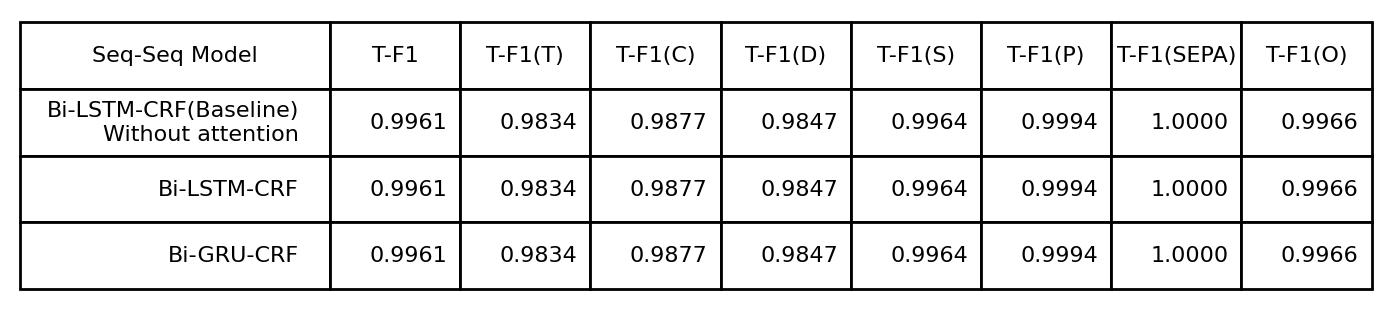

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

fig1,ax1 = plt.subplots(1,1,figsize = (2,1),dpi = 200)
ax1.axis('off')

table = ax1.table(result,colLabels=['Seq-Seq Model','T-F1','T-F1(T)','T-F1(C)','T-F1(D)','T-F1(S)','T-F1(P)','T-F1(SEPA)','T-F1(O)'],loc='best',colWidths=([0.5]+[0.21]*8))
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 2)

## 5.2 Ablation Study - different input embedding model

In [ ]:
result=[]

### 5.2.1 BiLSTM+FastText50

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM,embed_mode = 1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import pickle
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(classification_report(y_true_decode,y_pred_decode,digits=4))
print(result[-1])
pickle.dump(result,open("/content/drive/MyDrive/Result.pkl",'wb'))

100%|██████████| 26078/26078 [06:57<00:00, 62.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [00:58<00:00, 148.18it/s]



Epoch:1, Training loss: 28492.40, train acc: 0.9909, val loss: 1542.08, val acc: 0.9892, time: 592.92s


100%|██████████| 8705/8705 [00:58<00:00, 148.66it/s]



Epoch:2, Training loss: 5068.94, train acc: 0.9989, val loss: 928.27, val acc: 0.9949, time: 589.76s
              precision    recall  f1-score   support

           C     0.9932    0.9762    0.9846      1641
           D     0.9789    0.9322    0.9550       398
           O     0.9935    0.9990    0.9962     18985
           P     0.9987    0.9987    0.9987      3936
           S     0.9991    0.9907    0.9949      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     0.9875    0.9666    0.9770      1469

    accuracy                         0.9949     33354
   macro avg     0.9930    0.9805    0.9866     33354
weighted avg     0.9949    0.9949    0.9949     33354



### 5.2.2 BiLSTM+FastText50+POS-Tagging

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 100, HIDDEN_DIM,embed_mode = 2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(classification_report(y_true_decode,y_pred_decode,digits=4))

              precision    recall  f1-score   support

           C     0.9889    0.9775    0.9831      1641
           D     0.9919    0.9196    0.9544       398
           O     0.9936    0.9995    0.9965     18985
           P     0.9997    0.9987    0.9992      3936
           S     0.9994    0.9916    0.9955      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     0.9902    0.9673    0.9787      1469

    accuracy                         0.9952     33354
   macro avg     0.9948    0.9792    0.9868     33354
weighted avg     0.9952    0.9952    0.9952     33354



### 5.2.3 BiLSTM+FastText50+DomainFeature

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 55, HIDDEN_DIM,embed_mode = 0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(classification_report(y_true_decode,y_pred_decode,digits=4))

100%|██████████| 26078/26078 [06:49<00:00, 63.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [00:58<00:00, 148.30it/s]



Epoch:1, Training loss: 12204.21, train acc: 1.0000, val loss: 1361.49, val acc: 0.9961, time: 589.62s


100%|██████████| 8705/8705 [00:58<00:00, 148.47it/s]



Epoch:2, Training loss: 2381.55, train acc: 1.0000, val loss: 1448.21, val acc: 0.9961, time: 584.50s
              precision    recall  f1-score   support

           C     1.0000    0.9756    0.9877      1641
           D     1.0000    0.9698    0.9847       398
           O     0.9933    1.0000    0.9966     18985
           P     1.0000    0.9987    0.9994      3936
           S     1.0000    0.9928    0.9964      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     1.0000    0.9673    0.9834      1469

    accuracy                         0.9961     33354
   macro avg     0.9990    0.9863    0.9926     33354
weighted avg     0.9962    0.9961    0.9961     33354



### 5.2.4 BiLSTM+FastText50+POS-Tagging+DomainFeature

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 105, HIDDEN_DIM,embed_mode = 3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(classification_report(y_true_decode,y_pred_decode,digits=4))

100%|██████████| 26078/26078 [10:34<00:00, 41.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [02:05<00:00, 69.17it/s]



Epoch:1, Training loss: 12273.25, train acc: 1.0000, val loss: 1311.38, val acc: 0.9961, time: 1120.91s


100%|██████████| 8705/8705 [02:04<00:00, 69.90it/s]



Epoch:2, Training loss: 2439.77, train acc: 1.0000, val loss: 1397.10, val acc: 0.9961, time: 1107.71s
              precision    recall  f1-score   support

           C     1.0000    0.9756    0.9877      1641
           D     1.0000    0.9698    0.9847       398
           O     0.9933    1.0000    0.9966     18985
           P     1.0000    0.9987    0.9994      3936
           S     1.0000    0.9928    0.9964      3322
        SEPA     1.0000    1.0000    1.0000      3603
           T     1.0000    0.9673    0.9834      1469

    accuracy                         0.9961     33354
   macro avg     0.9990    0.9863    0.9926     33354
weighted avg     0.9962    0.9961    0.9961     33354



### 5.2.5 Draw Table

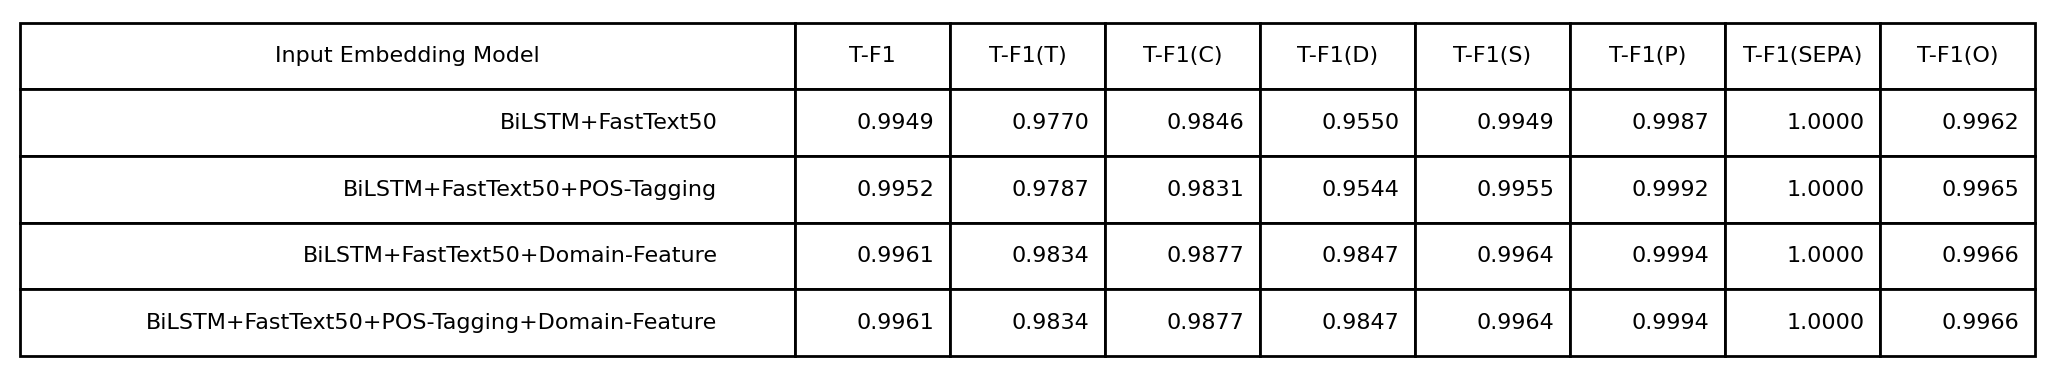

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

fig1,ax1 = plt.subplots(1,1,figsize = (5,1),dpi = 200)
ax1.axis('off')

numeric_data=[]
numeric_data.append(["BiLSTM+FastText50"])
numeric_data.append(["BiLSTM+FastText50+POS-Tagging"])
numeric_data.append(["BiLSTM+FastText50+Domain-Feature"])
numeric_data.append(["BiLSTM+FastText50+POS-Tagging+Domain-Feature"])

for i in range(4):
  temp=numeric_data[i]
  current = result[i]
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[10]).strip().split(" ")[1])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[8]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[2]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[3]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[6]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[5]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[7]).strip().split(" ")[3])
  temp.append(re.sub(r'( ){2,}',' ',current.split("\n")[4]).strip().split(" ")[3])
  # numeric_data.append(temp)


# df = pd.DataFrame(np.array(numeric_data), columns=['Input Embedding Model','T-F1','T-F1(T)','T-F1(C)','T-F1(D)','T-F1(S)','T-F1(P)','T-F1(SEPA)','T-F1(O)'])

table = ax1.table(numeric_data,colLabels=['Input Embedding Model','T-F1','T-F1(T)','T-F1(C)','T-F1(D)','T-F1(S)','T-F1(P)','T-F1(SEPA)','T-F1(O)'],loc='best',colWidths=([0.5]+[0.1]*8))
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 2)

## 5.3 Ablation Study - different attention strategy

In [ ]:
result=[]

### 5.3.0 Strategy: No attetion, No Domain Feature

In [ ]:
'''
Define Model
'''
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF_NATTNDF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,dropout_p=0.1,num_layers = 1):
        super(BiLSTM_CRF_NATTNDF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = num_layers

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)

        self.word_embeds = nn.Embedding(vocab_size, 50)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)
      

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
      # Do the forward algorithm to compute the partition function
      init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
      # START_TAG has all of the score.
      init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

      # Wrap in a variable so that we will get automatic backprop
      forward_var = init_alphas

      # Iterate through the sentence
      for feat in feats:
          alphas_t = []  # The forward tensors at this timestep
          for next_tag in range(self.tagset_size):
              # broadcast the emission score: it is the same regardless of
              # the previous tag
              emit_score = feat[next_tag].view(
                  1, -1).expand(1, self.tagset_size)
              # the ith entry of trans_score is the score of transitioning to
              # next_tag from i
              trans_score = self.transitions[next_tag].view(1, -1)
              # The ith entry of next_tag_var is the value for the
              # edge (i -> next_tag) before we do log-sum-exp
              next_tag_var = forward_var + trans_score + emit_score

              # The forward variable for this tag is log-sum-exp of all the
              # scores.
              alphas_t.append(log_sum_exp(next_tag_var).view(1))

          forward_var = torch.cat(alphas_t).view(1, -1)
      terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
      alpha = log_sum_exp(terminal_var)
      return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence_idx).view(len(sentence_idx), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)
        lstm_feats = self.dropout(lstm_feats)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)
        
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF_NATTNDF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,pp_training_data_sents[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["No Attention without Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 8705/8705 [01:49<00:00, 79.40it/s] 



Epoch:1, Training loss: 28914.80, train acc: 0.9916, val loss: 1580.94, val acc: 0.9898, time: 1208.97s


100%|██████████| 8705/8705 [01:47<00:00, 80.88it/s]



Epoch:2, Training loss: 5153.88, train acc: 0.9987, val loss: 975.76, val acc: 0.9950, time: 1044.47s


### 5.3.1 Strategy: No attetion

In [ ]:
'''
Define No Attention Model
'''
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF_NoAttention(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,num_layers = 1):
        super(BiLSTM_CRF_NoAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim+5, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()
        # FastText50 + Domain Feature
        embeds = torch.cat((self.word_embeds(sentence_idx),get_domain_feature(sentence)),dim=1).view(len(sentence_idx), 1, -1)
        
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)

        lstm_feats = self.hidden2tag(lstm_out)

        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

no_attention_model = BiLSTM_CRF_NoAttention(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM).to(device)
optimizer = optim.SGD(no_attention_model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    no_attention_model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        no_attention_model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = no_attention_model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    no_attention_model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(no_attention_model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(no_attention_model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = no_attention_model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["No Attention With Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 8705/8705 [00:59<00:00, 146.75it/s]



Epoch:1, Training loss: 14154.02, train acc: 0.9999, val loss: 1322.01, val acc: 0.9960, time: 593.91s


100%|██████████| 8705/8705 [00:59<00:00, 146.89it/s]



Epoch:2, Training loss: 220.10, train acc: 1.0000, val loss: 1405.21, val acc: 0.9961, time: 567.38s


### 5.3.2 Strategy: Attention on Encoder and Decoder With Scaled Dot Product Without Domain Feature

In [ ]:
'''
Define Attention On Encoder Model with Scaled Dot Product
'''
from tensorflow.python.framework.ops import Tensor
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF_Attention_On_Encoder(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    # We will practise the scaled dot product attention in the last section
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"
    ATTN_TYPE_COS = "Content-based COS" 

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF_Attention_On_Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.num_layers = 1


        self.word_embeds = nn.Embedding(vocab_size, 50)

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=self.num_layers, bidirectional=True)
      

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        self.out = nn.Linear(1, self.tagset_size*2)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device),
                torch.randn(self.num_layers*2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score

                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))

            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence_idx, sentence):
        self.hidden = self.init_hidden()

        # FastText50 + Domain Feature
        embeds = self.word_embeds(sentence_idx).view(len(sentence_idx), 1, -1)
        
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence_idx), self.hidden_dim)
        res=None
        for i,each in enumerate(lstm_out):
          concat_output = self.cal_attention(each.unsqueeze(0), self.hidden[-1][-1], BiLSTM_CRF_Attention_On_Encoder.ATTN_TYPE_SCALE_DOT_PRODUCT)
          output = F.log_softmax(concat_output)
          if i == 0:
            res = output
          else:
            res = torch.cat((res,output),dim=0)

        lstm_feats = self.hidden2tag(res)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence_idx, tags,sentence):
        sent_feats = self._get_lstm_features(sentence_idx,sentence)

        forward_score = self._forward_alg(sent_feats)
        gold_score = self._score_sentence(sent_feats, tags)
        return forward_score - gold_score

    def cal_attention(self, hidden, encoder_hiddens, method):
        if method == BiLSTM_CRF_Attention_On_Encoder.ATTN_TYPE_DOT_PRODUCT:
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            attn_weights = F.softmax(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T+ hidden
            
        elif method == BiLSTM_CRF_Attention_On_Encoder.ATTN_TYPE_SCALE_DOT_PRODUCT:
            attn_weights = F.softmax(1/np.sqrt(self.hidden_dim)*torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))

            concat_output = attn_output[0].T + hidden
        elif method == BiLSTM_CRF_Attention_On_Encoder.ATTN_TYPE_COS:
            attn_weights =  F.softmax(torch.cos(torch.bmm(hidden.T.unsqueeze(0), encoder_hiddens.unsqueeze(0))),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.T.unsqueeze(0))
            concat_output = attn_output[0].T + hidden
        return concat_output

    def forward(self, sentence_idx,sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence_idx,sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF_Attention_On_Encoder(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["Attention on Encoder and Decoder With Scaled Dot Product Without Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 8705/8705 [01:51<00:00, 77.84it/s]



Epoch:1, Training loss: 157926.91, train acc: 0.9830, val loss: 3922.20, val acc: 0.9808, time: 1089.04s


100%|██████████| 8705/8705 [01:51<00:00, 77.86it/s] 



Epoch:2, Training loss: 6787.79, train acc: 0.9957, val loss: 3198.75, val acc: 0.9928, time: 1064.80s


### 5.3.3 Strategy: Attention on Decoder With Scaled Dot Product Without Domain Feature

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM,embed_mode = 1,attn_type=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["Attention on Decoder With Scaled Dot Product without Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [12:04<00:00, 36.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:40<00:00, 86.23it/s] 



Epoch:1, Training loss: 23032.97, train acc: 0.9935, val loss: 1516.38, val acc: 0.9914, time: 1025.79s


100%|██████████| 8705/8705 [01:41<00:00, 85.96it/s] 



Epoch:2, Training loss: 2026.90, train acc: 0.9991, val loss: 1077.73, val acc: 0.9951, time: 1211.96s


### 5.3.4 Strategy: Attention on Decoder With Dot Product Without Domain Feature

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM,embed_mode = 1,attn_type=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["Attention on Decoder With Dot Product Without Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [11:28<00:00, 37.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:42<00:00, 85.24it/s] 



Epoch:1, Training loss: 23715.75, train acc: 0.9945, val loss: 1557.27, val acc: 0.9919, time: 981.14s


100%|██████████| 8705/8705 [01:41<00:00, 86.13it/s] 



Epoch:2, Training loss: 2195.84, train acc: 0.9987, val loss: 1125.07, val acc: 0.9949, time: 986.47s


### 5.3.5 Strategy: Attention on Decoder With Cosine Without Domain Feature

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 50, HIDDEN_DIM,embed_mode = 1,attn_type=2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["Attention on Decoder With Cosine Without Domain Feature",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [10:39<00:00, 40.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:229: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:28<00:00, 98.33it/s] 



Epoch:1, Training loss: 23691.58, train acc: 0.9934, val loss: 1564.40, val acc: 0.9911, time: 903.04s


100%|██████████| 8705/8705 [01:30<00:00, 96.70it/s] 



Epoch:2, Training loss: 2157.76, train acc: 0.9983, val loss: 1095.61, val acc: 0.9945, time: 888.15s


### 5.3.6 Draw Table

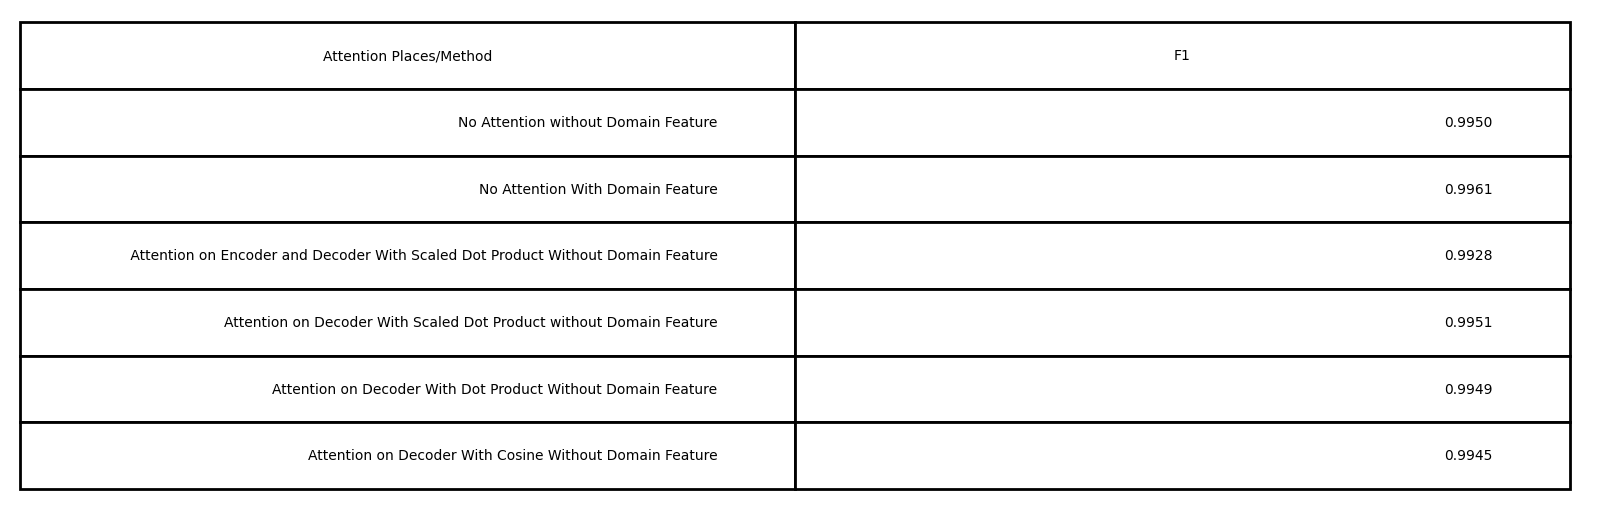

In [ ]:
result=[["No Attention without Domain Feature","0.9950"],["No Attention With Domain Feature",0.9961],[" Attention on Encoder and Decoder With Scaled Dot Product Without Domain Feature",0.9928],["Attention on Decoder With Scaled Dot Product without Domain Feature",0.9951],["Attention on Decoder With Dot Product Without Domain Feature",0.9949],["Attention on Decoder With Cosine Without Domain Feature",0.9945]]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

fig1,ax1 = plt.subplots(1,1,figsize = (5,1),dpi = 200)
ax1.axis('off')
table = ax1.table(np.array(result),colLabels=['Attention Places/Method','F1'],loc='best')
table.set_fontsize(8)
table.scale(2, 2)

##5.4 Ablation Study - different Stacked layer

### 5.4.1 One Layer

In [ ]:
'''
This has been trainied and evaluated on the best model before.[Section 3]
So the data is directly comes from Section3
'''
result = [["1 Layer",0.9961]]

### 5.4.2 Three Layers

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 55, HIDDEN_DIM,num_layers = 3).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["3 Layers",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [13:41<00:00, 31.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:54<00:00, 76.03it/s]



Epoch:1, Training loss: 61425.47, train acc: 0.9915, val loss: 2478.55, val acc: 0.9882, time: 1175.89s


100%|██████████| 8705/8705 [01:53<00:00, 76.55it/s] 



Epoch:2, Training loss: 1074.41, train acc: 0.9997, val loss: 1965.76, val acc: 0.9959, time: 1166.71s


### 5.4.3 Five Layers

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 55, HIDDEN_DIM,num_layers = 5).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["5 Layers",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [09:46<00:00, 44.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:05<00:00, 132.22it/s]



Epoch:1, Training loss: 127792.23, train acc: 0.5704, val loss: 42153.34, val acc: 0.5692, time: 828.59s


100%|██████████| 8705/8705 [01:05<00:00, 132.63it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch:2, Training loss: 125633.48, train acc: 0.5704, val loss: 41986.98, val acc: 0.5692, time: 789.99s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.4.3 Ten Layers

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 55, HIDDEN_DIM,num_layers = 10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["10 Layers",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [13:10<00:00, 32.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [01:33<00:00, 92.90it/s] 



Epoch:1, Training loss: 127820.73, train acc: 0.5704, val loss: 42050.60, val acc: 0.5692, time: 1159.07s


100%|██████████| 8705/8705 [01:32<00:00, 94.57it/s] 
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch:2, Training loss: 125597.99, train acc: 0.5704, val loss: 41995.03, val acc: 0.5692, time: 1131.57s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.4.4 Draw Table

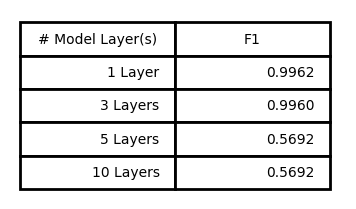

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

fig1,ax1 = plt.subplots(1,1,figsize = (2,1),dpi = 200)
ax1.axis('off')
table = ax1.table(np.array(result),colLabels=['# Model Layer(s)','F1'],loc='best')

## 5.5 Ablation Study - with/without CRF

###5.5.1 With CRF

In [ ]:
'''
This has been trainied and evaluated on the best model before.[Section 3]
So the data is directly comes from Section3
'''
result = [["With CRF",0.9961]]

### 5.5.2 Without CRF

In [ ]:
'''
Set up hyperparameter
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, 55, HIDDEN_DIM,with_crf= False).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
'''
Start Training
'''
import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report
y_pred = None
y_true = None

for epoch in range(2):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in tqdm(enumerate(train_input_index),total = len(train_input_index)):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets,(pp_training_data_sents)[i][0])

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index,pp_training_data_sents)
    y_pred,y_true, val_acc = cal_acc(model,val_input_index,val_output_index,pp_validation_data_sents)

    val_loss = 0
    for i, idxs in tqdm(enumerate(val_input_index),total = len(val_input_index)):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in, targets,pp_validation_data_sents[i][0])
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    print("\nEpoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


def decode_output(output_list):
  ix_to_tag = {v:k for k,v in tag_to_ix.items()}
  return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

result.append(["Without CRF",re.sub(r'( ){2,}',' ',classification_report(y_true_decode,y_pred_decode,digits=4).split("\n")[10]).strip().split(" ")[1]])

100%|██████████| 26078/26078 [02:26<00:00, 177.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8705/8705 [00:16<00:00, 543.99it/s]



Epoch:1, Training loss: -313020768.29, train acc: 0.5704, val loss: -186859971.00, val acc: 0.5693, time: 302.47s


100%|██████████| 8705/8705 [00:16<00:00, 533.04it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch:2, Training loss: -711675617.91, train acc: 0.5706, val loss: -299258589.04, val acc: 0.5697, time: 262.91s
              precision    recall  f1-score   support

           C     0.0000    0.0000    0.0000      1641
           D     0.0000    0.0000    0.0000       398
           O     0.5700    0.9991    0.7258     18985
           P     0.0000    0.0000    0.0000      3936
           S     0.4416    0.0102    0.0200      3322
        SEPA     0.0000    0.0000    0.0000      3603
           T     0.0000    0.0000    0.0000      1469

    accuracy                         0.5697     33354
   macro avg     0.1445    0.1442    0.1065     33354
weighted avg     0.3684    0.5697    0.4151     33354



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Draw Table

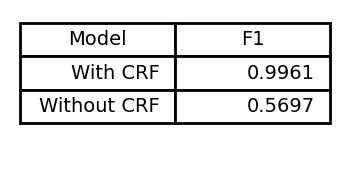

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

fig1,ax1 = plt.subplots(1,1,figsize = (2,1),dpi = 200)
ax1.axis('off')
table = ax1.table(np.array(result),colLabels=['Model','F1'],loc='best')
